In [143]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandrakozevnikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
!kaggle competitions download -c hse-nlp-bootcamp

Traceback (most recent call last):
  File "/Users/aleksandrakozevnikova/opt/anaconda3/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/aleksandrakozevnikova/.kaggle. Or use the environment method.


In [145]:
df = pd.read_csv('train_ml.csv')
df

bank                                              feeds  \
0                ubrr  –ú–Ω–æ–≥–æ –ª–µ—Ç —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º —ç—Ç–æ–≥–æ –±–∞–Ω–∫–∞, –Ω–æ¬†–ø–æ—Å...   
1         fk_otkritie  –ì. –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É, —É–ª. –õ–µ–Ω–∏–Ω–∞, 48. –ë—ã–ª–∏ 10.12....   
2            alfabank  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ!–†–∞–Ω–µ–µ —É–∂–µ –æ—Å—Ç–∞–≤–ª—è–ª –æ—Ç–∑—ã–≤ –æ –≤–∞—à–µ–º ...   
3                 vtb  –û–±—Ä–∞—â–∞—é—Å—å –∫ –í–∞–º —Å –∂–∞–ª–æ–±–æ–π –Ω–∞ –Ω–µ–∑–∞–∫–æ–Ω–Ω–æ–µ —Å–ø–∏—Å–∞–Ω...   
4       promsvyazbank  –ò–º–µ—é –ø–æ—Ç—Ä–µ–±–∏—Ç–µ–ª—å—Å–∫–∏–π –∫—Ä–µ–¥–∏—Ç, –≤–∑—è—Ç—ã–π –≤ –°–≤—è–∑—å-–±–∞...   
...               ...                                                ...   
74995           trust  –¢—Ä–∏ –≥–æ–¥–∞ –¥–ª–∏—Ç—Å—è —ç–ø–æ–ø–µ—è —Å –∑–∞–∫—Ä—ã—Ç–∏–µ–º –∫—Ä–µ–¥–∏—Ç–Ω–æ–π –∫...   
74996     fk_otkritie  –Ø–≤–ª—è–ª—Å—è –∫–ª–∏–µ–Ω—Ç–æ–º –ë–∏–Ω–±–∞–Ω–∫–∞, –ø–æ–∫–∞ –ø–æ—Å–ª–µ —Å–ª–∏—è–Ω–∏—è ...   
74997        sberbank  8 –º–∞—è 2016 –≥. –º–Ω–æ—é –≤–Ω–æ—Å–∏–ª–∏—Å—å –¥–µ–Ω—å–≥–∏ –Ω–∞ –±–∞–Ω–∫–æ–≤—Å...   
74998         uralsib  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! –°–µ–≥–æ–¥–Ω—è 21.04.2020 –∑–∞—Ö–æ–∂—É –≤ –º–æ–±–∏...   
74999  bnpparibaseast  –£–≤–∞–∂–∞–µ–º–æ–µ —Ä—É–∫–æ–≤–æ–¥—Å—Ç–≤–æ –±–∞–Ω–∫–∞!–ï—Å–ª–∏ –≤—Å–µ —É—Å–ª—É–≥–∏ –≤–∞...   

       grades              date  
0         1.0  16.02.2017 16:10  
1         2.0   13.12.2016 1:05  
2         NaN  28.06.2019 13:54  
3         NaN  15.07.2020 14:54  
4         2.0   04.08.2020 6:38  
...       ...               ...  
74995     1.0  26.10.2016 11:03  
74996     2.0  01.02.2020 21:07  
74997     1.0  14.06.2016 16:03  
74998     3.0   21.04.2020 8:24  
74999     1.0  01.06.2011 13:05  

[75000 rows x 4 columns]

# Some EDA

–°—Ä–∞–∑—É –≤–∏–¥–∏–º, —á—Ç–æ –≤ —Å—Ç–æ–ª–±—Ü–µ —Å —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π (`grades`) –µ—Å—Ç—å –ø—Ä–æ–ø—É—Å–∫–∏. –í —ç—Ç–æ–º –Ω–æ—É—Ç–±—É–∫–µ –±—É–¥–µ–º –æ–±—É—á–∞—Ç—å—Å—è –Ω–∞ –æ—Ç–∑—ã–≤–∞—Ö, –¥–ª—è –∫–æ—Ç–æ—Ä—ã—Ö –µ—Å—Ç—å –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –æ –∑–Ω–∞—á–µ–Ω–∏–∏ —Ç–∞—Ä–≥–µ—Ç–∞. **–ù–æ —ç—Ç–æ –Ω–µ –µ–¥–∏–Ω—Å—Ç–≤–µ–Ω–Ω—ã–π –ø–æ–¥—Ö–æ–¥. –ü–æ–¥—É–º–∞–π—Ç–µ, —á—Ç–æ –µ—â—ë –º–æ–∂–Ω–æ —Å–¥–µ–ª–∞—Ç—å**

–ü–æ—Å–º–æ—Ç—Ä–∏–º, –µ—Å—Ç—å –ª–∏ –ø—Ä–æ–ø—É—Å–∫–∏ –≤ –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bank    75000 non-null  object 
 1   feeds   75000 non-null  object 
 2   grades  51476 non-null  float64
 3   date    75000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


–°—Ä–∞–∑—É –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Å—Ç–æ–ª–±–µ—Ü —Å –º–µ—Ç–∫–æ–π –≤—Ä–µ–º–µ–Ω–∏ –∫ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–º—É —Ñ–æ—Ä–º–∞—Ç—É. –ò —É–¥–∞–ª–∏–º —Å—Ç—Ä–æ—á–∫–∏ —Å –ø—Ä–æ–ø—É—Å–∫–∞–º–∏ –≤ —Ç–∞—Ä–≥–µ—Ç–µ

In [146]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df = df.dropna()
#df = df.fillna(method = 'pad')
df = df.astype({'grades': 'int32'})
df

bank                                              feeds  \
0                ubrr  –ú–Ω–æ–≥–æ –ª–µ—Ç —è–≤–ª—è—é—Å—å –∫–ª–∏–µ–Ω—Ç–æ–º —ç—Ç–æ–≥–æ –±–∞–Ω–∫–∞, –Ω–æ¬†–ø–æ—Å...   
1         fk_otkritie  –ì. –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É, —É–ª. –õ–µ–Ω–∏–Ω–∞, 48. –ë—ã–ª–∏ 10.12....   
4       promsvyazbank  –ò–º–µ—é –ø–æ—Ç—Ä–µ–±–∏—Ç–µ–ª—å—Å–∫–∏–π –∫—Ä–µ–¥–∏—Ç, –≤–∑—è—Ç—ã–π –≤ –°–≤—è–∑—å-–±–∞...   
7      homecreditbank  –•–æ—á—É –≤—ã—Ä–∞–∑–∏—Ç—å –≥–ª—É–±–æ–∫—É—é –±–ª–∞–≥–æ–¥–∞—Ä–Ω–æ—Å—Ç—å –≤—Å–µ–º —Å–æ—Ç—Ä...   
8                 vtb  6 –º–∞—Ä—Ç–∞ 2019–≥. –í 10:33 –ø—Ä–∏ –ø—Ä–æ—Ö–æ–¥–µ –≤ –º–µ—Ç—Ä–æ "–ö—É...   
...               ...                                                ...   
74995           trust  –¢—Ä–∏ –≥–æ–¥–∞ –¥–ª–∏—Ç—Å—è —ç–ø–æ–ø–µ—è —Å –∑–∞–∫—Ä—ã—Ç–∏–µ–º –∫—Ä–µ–¥–∏—Ç–Ω–æ–π –∫...   
74996     fk_otkritie  –Ø–≤–ª—è–ª—Å—è –∫–ª–∏–µ–Ω—Ç–æ–º –ë–∏–Ω–±–∞–Ω–∫–∞, –ø–æ–∫–∞ –ø–æ—Å–ª–µ —Å–ª–∏—è–Ω–∏—è ...   
74997        sberbank  8 –º–∞—è 2016 –≥. –º–Ω–æ—é –≤–Ω–æ—Å–∏–ª–∏—Å—å –¥–µ–Ω—å–≥–∏ –Ω–∞ –±–∞–Ω–∫–æ–≤—Å...   
74998         uralsib  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! –°–µ–≥–æ–¥–Ω—è 21.04.2020 –∑–∞—Ö–æ–∂—É –≤ –º–æ–±–∏...   
74999  bnpparibaseast  –£–≤–∞–∂–∞–µ–º–æ–µ —Ä—É–∫–æ–≤–æ–¥—Å—Ç–≤–æ –±–∞–Ω–∫–∞!–ï—Å–ª–∏ –≤—Å–µ —É—Å–ª—É–≥–∏ –≤–∞...   

       grades                date  
0           1 2017-02-16 16:10:00  
1           2 2016-12-13 01:05:00  
4           2 2020-08-04 06:38:00  
7           5 2015-04-19 20:11:00  
8           2 2019-03-28 18:36:00  
...       ...                 ...  
74995       1 2016-10-26 11:03:00  
74996       2 2020-02-01 21:07:00  
74997       1 2016-06-14 16:03:00  
74998       3 2020-04-21 08:24:00  
74999       1 2011-06-01 13:05:00  

[51476 rows x 4 columns]

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —á–∏—Å–ª–∞ –æ—Ç–∑—ã–≤–æ–≤ –ø–æ –±–∞–Ω–∫–∞–º

In [7]:
feeds_by_bank_count = df.bank.value_counts()
feeds_by_bank_count

sberbank          12898
vtb                7457
tcs                6425
fk_otkritie        3651
homecreditbank     3408
                  ...  
intesa               43
bystrobank           42
primsotsbank         39
rncb                 37
rnbank               36
Name: bank, Length: 69, dtype: int64

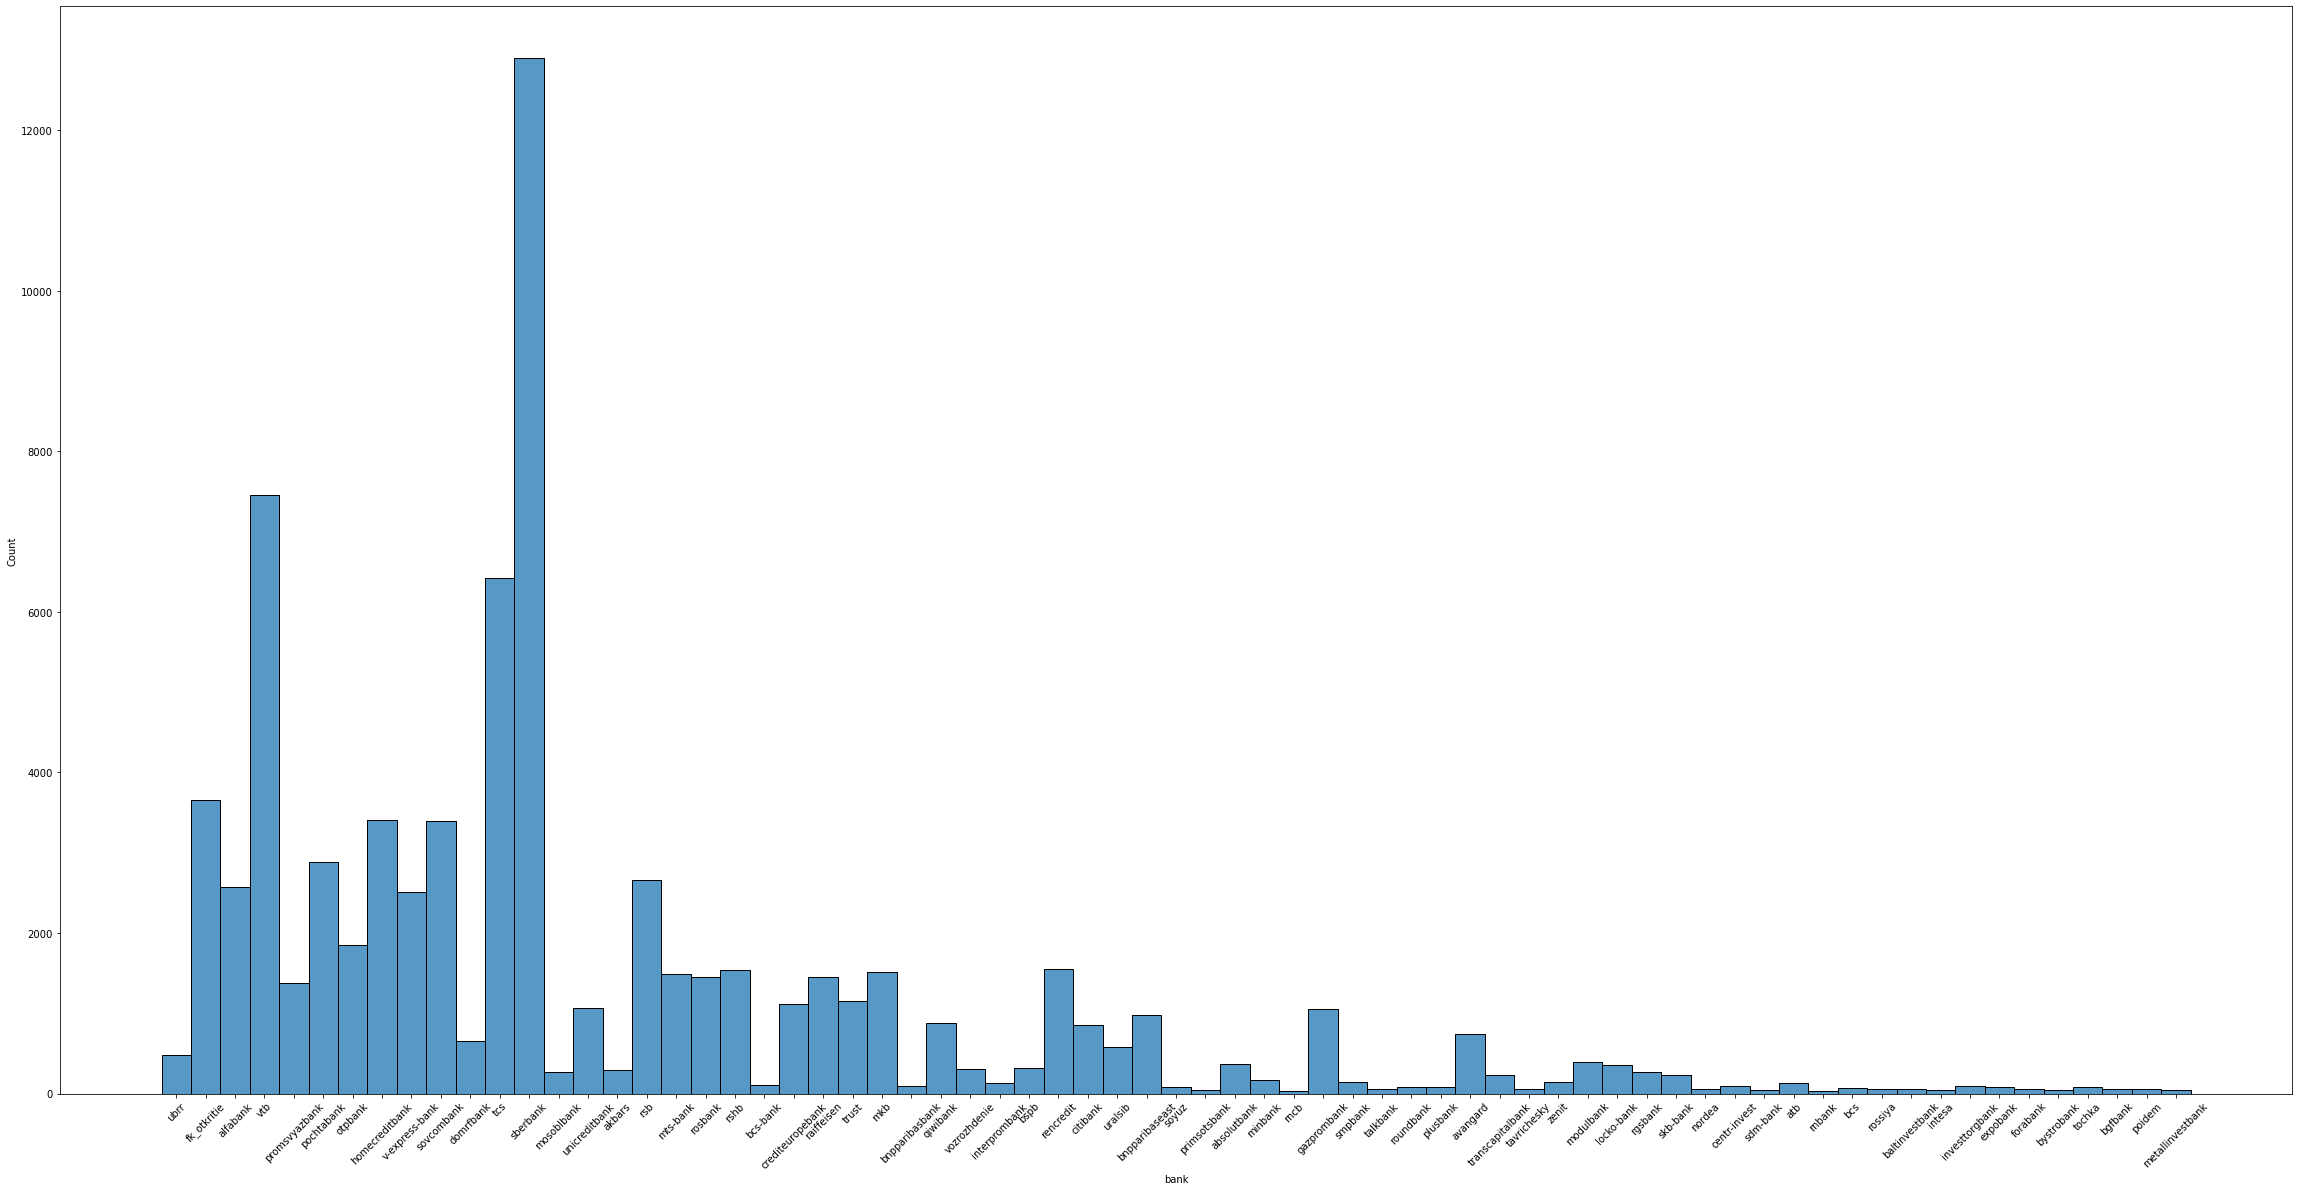

In [8]:
plt.figure(figsize=(40,20))
sns.histplot(data=df.sort_values(by='bank'), 
             x=df.bank, )
plt.xticks(rotation=45)
plt.show()

–ì–ª—è–Ω–µ–º –Ω–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∏–µ–Ω—Ç—Å–∫–∏—Ö –æ—Ü–µ–Ω–æ–∫

In [9]:
df.grades.value_counts().sort_index()

1    40288
2     8288
3     3389
4     2186
5    20849
Name: grades, dtype: int64

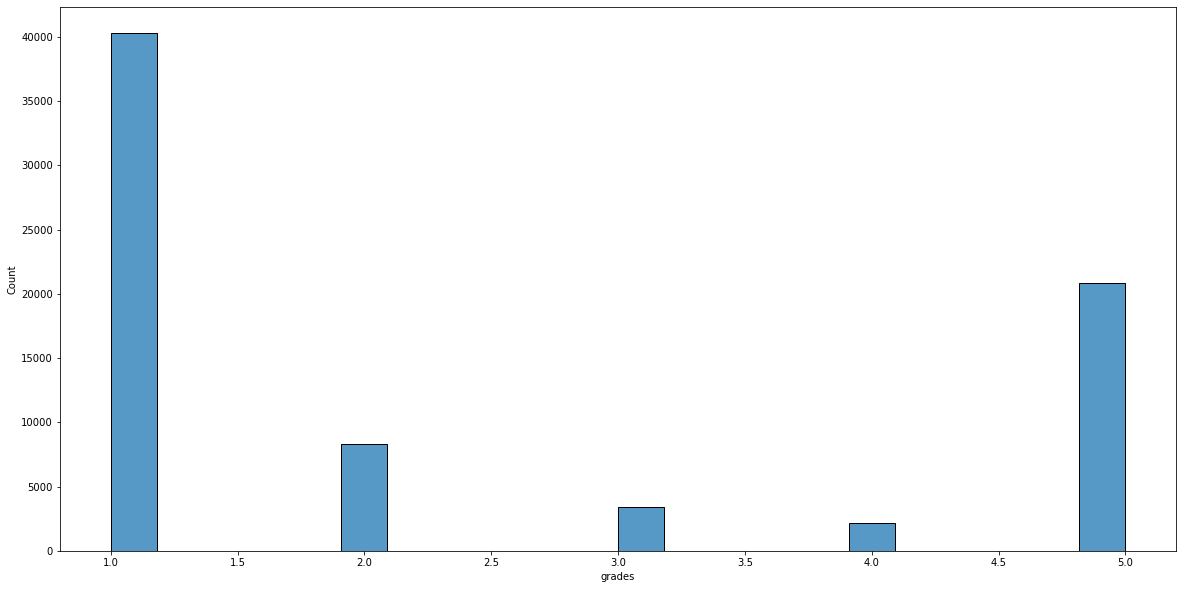

In [10]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df, 
             x=df.grades, )
plt.show()

–¢–∞–∫–∂–µ –Ω–∞—Å –∏–Ω—Ç–µ—Ä–µ—Å—É—é—Ç –¥–ª–∏–Ω—ã –æ—Ç–∑—ã–≤–æ–≤

In [11]:
df['sym_len'] = df.feeds.apply(len)
df['word_len'] = df.feeds.apply(lambda x: len(x.split()))

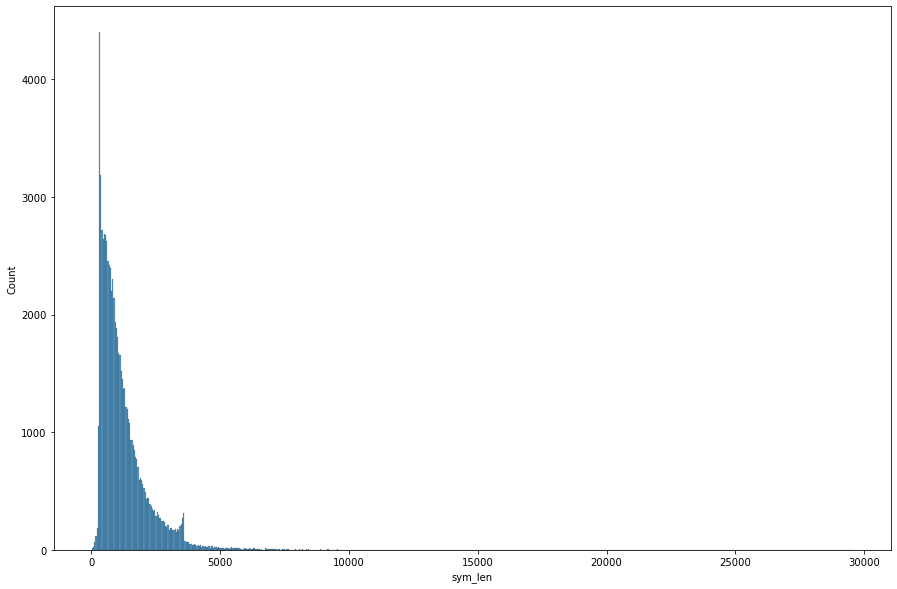

In [12]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.sym_len)
plt.show()

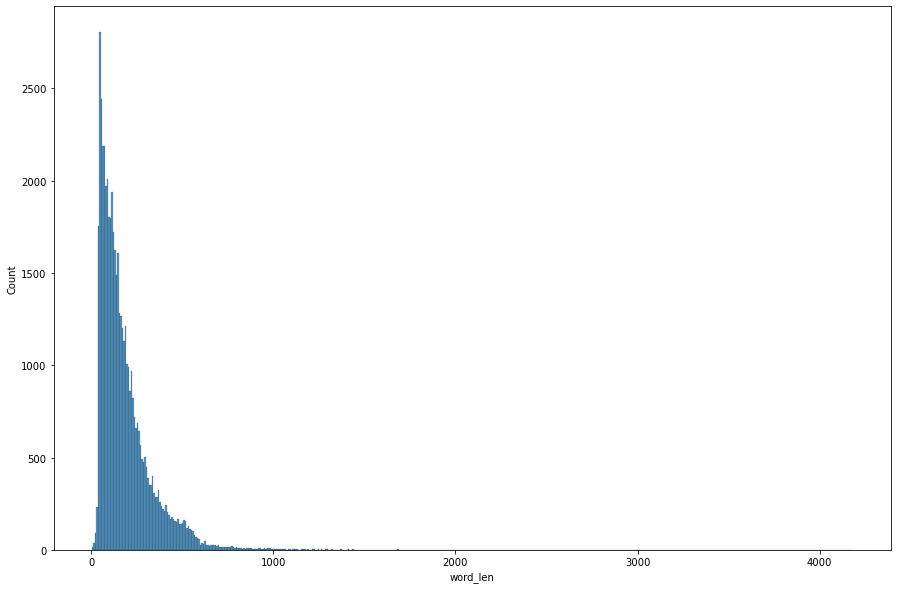

In [16]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.word_len)
plt.show()

–û–±—Ä–∞—Ç–∏—Ç–µ –≤–Ω–∏–º–∞–Ω–∏–µ, —É —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–π –æ—á–µ–Ω—å –¥–ª–∏–Ω–Ω—ã–µ —Ö–≤–æ—Å—Ç—ã

# Baseline (tf-idf + logreg)

–ü–æ–¥–≥–æ—Ç–∞–≤–ª–∏–≤–∞–µ–º —Ç–µ–∫—Å—Ç—ã –æ—Ç–∑—ã–≤–æ–≤ (–≤–∑—è—Ç–æ –∏–∑ –Ω–æ—É—Ç–±—É–∫–∞ –≤—Ç–æ—Ä–æ–≥–æ –∑–∞–Ω—è—Ç–∏—è üòÉ)

In [147]:
m = MorphAnalyzer()
regex = re.compile("[–ê-–Ø–∞-—èA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [148]:
#lemmas = list(map(clean_text, df['feeds']))
    
#df['lemmas'] = lemmas
#df.sample(5)
lemmas = df.feeds.apply(lambda i: clean_text(i))

–ë—É–¥–µ–º –æ–±—É—á–∞—Ç—å—Å—è –∏—Å–∫–ª—é—á–∏—Ç–µ–ª—å–Ω–æ –Ω–∞ —Ç–µ–∫—Å—Ç–∞—Ö –æ—Ç–∑—ã–≤–æ–≤ (–ø—Ä–∏–∑–Ω–∞–∫–∏ `bank`–∏ `date` –Ω–µ –∏—Å–ø–æ–ª—å–∑—É–µ–º –æ—Ç —Å–ª–æ–≤–∞ —Å–æ–≤—Å–µ–º -- **–º—ã –Ω–µ –∏—Å–ø–æ–ª—å–∑—É–µ–º, –∞ –≤—ã –≤ —Å–≤–æ–∏—Ö —Ä–µ—à–µ–Ω–∏—è—Ö –ø–æ–ø—Ä–æ–±—É–π—Ç–µ**)

In [149]:
y_train = df.grades
y_train = y_train.reset_index().drop(columns='index')
del df # –≤—ã—Å–≤–æ–±–æ–¥–∏–º –æ–ø–µ—Ä–∞—Ç–∏–≤—É, –æ–Ω–∞ –Ω–∞–º –Ω–µ –ø–æ–º–µ—à–∞–µ—Ç

–û–±—É—á–∏–º—Å—è –Ω–∞ –≤—Å–µ—Ö –æ–±—ä–µ–∫—Ç–∞—Ö, –∞ –ø–æ—Ç–æ–º —Å–¥–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –Ω–∞ —Ç–µ—Å—Ç–µ –∏–∑ —Å–æ—Ä–µ–≤–Ω–æ–≤–∞–Ω–∏—è. –ù–∏ –±–æ–ª—å—à–µ, –Ω–∏ –º–µ–Ω—å—à–µ

In [150]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 2), max_features = 4096) # –∏—Å–ø–æ–ª—å–∑—É–µ–º —É–Ω–∏-, –±–∏–≥—Ä–∞–º–º—ã
bow = vec.fit_transform(lemmas)
clf = LogisticRegression(random_state=42, max_iter=500, warm_start=True)


CPU times: user 17.9 s, sys: 1.78 s, total: 19.6 s
Wall time: 21 s


In [151]:
y_train

grades
0           1
1           2
2           2
3           5
4           2
...       ...
51471       1
51472       2
51473       1
51474       3
51475       1

[51476 rows x 1 columns]

In [152]:
# –Ω–µ–±–æ–ª—å—à–æ–π —Ç—Ä—é–∫: –±—É–¥–µ–º –æ–±—É—á–∞—Ç—å—Å—è —á–∞—Å—Ç—è–º–∏
ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10) # —Ä–∞–∑–æ–±—ä–µ–º –Ω–∞ 10 —á–∞—Å—Ç–µ–π
# –∏ –ø–æ–¥–º–µ—à–∞–µ–º –∫ –∫–∞–∂–¥–æ–º—É –∫—É—Å–∫—É —Å–ª—É—á–∞–π–Ω—ã—Ö –æ–±—ä–µ–∫—Ç–æ–≤
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=1000))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    clf.fit(bow[chunk, :], y_train.iloc[chunk])


  0%|          | 0/10 [00:00<?, ?it/s]/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 10%|‚ñà         | 1/10 [00:00<00:08,  1.10it/s]/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|‚ñà‚ñà        | 2/10 [00:01<00:06,  1.17it/s]/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or

–ó–∞–≥—Ä—É–∑–∏–º —Ç–µ—Å—Ç. –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∞–µ–º –æ—Ç–∑—ã–≤—ã –≤ –Ω–µ–º –∏ —Å–¥–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è

In [153]:
test = pd.read_csv('new_test_ml.csv', index_col=0)
test

bank                                              feeds  \
0            sberbank  –û—Ñ–æ—Ä–º–ª—è–µ–º –∏–ø–æ—Ç–µ–∫—É –≤ –°–±–µ—Ä–±–∞–Ω–∫–µ. 22.06.2020 –±—ã–ª–∏...   
1            alfabank  –ö—Ä–∞—Ç–∫–æ–µ —Å–æ–¥–µ—Ä–∂–∞–Ω–∏–µ: –Ω–µ —Ä–µ–∫–æ–º–µ–Ω–¥—É—é –±—Ä–∞—Ç—å –∫—Ä–µ–¥–∏—Ç...   
2      v-express-bank  –î–æ–±—Ä—ã–π –¥–µ–Ω—å, —É–≤–∞–∂–∞–µ–º—ã–µ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–∏ —Å–ª—É–∂–±—ã –∫–æ–Ω—Ç—Ä...   
3      homecreditbank  –û–±—Ä–∞—â–∞–ª—Å—è –∑–∞ –ø–æ–ª—É—á–µ–Ω–∏–µ–º –∫–∞—Ä—Ç—ã "–ó–µ–ª–µ–Ω–∞—è –ø–æ–ª—å–∑–∞"...   
4                 vtb  20.05.2016 –æ–±—Ä–∞—Ç–∏–ª–∞—Å—å –≤ –æ—Ç–¥–µ–ª–µ–Ω–∏–µ –±–∞–Ω–∫–∞ –Ω–∞ –ø—Ä–æ...   
...               ...                                                ...   
17215        sberbank  21.09.2018 –≤ 15:26:56, —è, –û-–≤–∞ –ö. –ö., —Å–Ω–∏–º–∞–ª–∞ ...   
17216  homecreditbank  –ù–∞–≤–µ—Ä–Ω—è–∫–∞ –Ω–µ –∑–∞—Å—á–∏—Ç–∞—é—Ç, –Ω–æ —Ç–µ–º –Ω–µ –º–µ–Ω–µ–µ. –ù—É–∂–Ω–∞...   
17217   interprombank  15.08.2019 —è, –∫–∞–∫ —Ñ–∏–∑.–ª–∏—Ü–æ –æ–±—Ä–∞—Ç–∏–ª–∞—Å—å –≤ –æ—Ñ–∏—Å –Ω...   
17218         otpbank  –£ –±–∞–Ω–∫–∞ –µ—Å—Ç—å —Ä–µ–∫–ª–∞–º–Ω—ã–π –ø—Ä–æ–¥—É–∫—Ç-–∏–≥—Ä–∞ "–ú–æ–∏ —Ä—ã–±–∫–∏...   
17219        sberbank  26 –º–∞—è 2015 –≥–æ–¥–∞ –º–Ω–æ—é –±—ã–ª–∞ —Å–æ–≤–µ—Ä—à–µ–Ω–∞ –æ–ø–µ—Ä–∞—Ü–∏—è ...   

                   date  
0      01.07.2020 10:53  
1      20.06.2019 13:19  
2      20.02.2016 11:46  
3      06.05.2019 15:48  
4      23.05.2016 15:41  
...                 ...  
17215  22.09.2018 16:08  
17216   06.10.2011 9:35  
17217  21.08.2019 14:13  
17218  29.05.2020 16:12  
17219  02.06.2015 15:44  

[17220 rows x 3 columns]

In [154]:
#with Pool(4) as p:
    #lemmas_test = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))
#lemmas_test = list(map(clean_text, test['feeds']))
lemmas_test = test.feeds.apply(lambda i: clean_text(i))

In [155]:
pred = clf.predict(vec.transform(lemmas_test))
pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [156]:
sol = pd.DataFrame({'inds': test.index,
                    'grades': pred})
sol

inds  grades
0          0       1
1          1       1
2          2       1
3          3       1
4          4       1
...      ...     ...
17215  17215       1
17216  17216       1
17217  17217       1
17218  17218       1
17219  17219       1

[17220 rows x 2 columns]

In [158]:
sol.to_csv('new_baseline.csv', index=False)

–ö—Å—Ç–∞—Ç–∏, –µ—Å–ª–∏ –æ–±—Ä–∞—Ç–∏—Ç–µ –≤–Ω–∏–º–∞–Ω–∏–µ –Ω–∞ —Å–æ–¥–µ—Ä–∂–∏–º–æ–µ –≤–µ–∫—Ç–æ—Ä–∞ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤, —Ç–æ –Ω–∞–≤–µ—Ä–Ω—è–∫–∞ –∑–∞–º–µ—Ç–∏—Ç–µ, —á—Ç–æ –º–æ–¥–µ–ª—å –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ—Ç —Ç–æ–ª—å–∫–æ 1 –∏ 5, —Ä–µ–¥–∫–æ 2 –∏ 3 –∏ –≤–æ–æ–±—â–µ –Ω–∏–∫–æ–≥–¥–∞ –∫–ª–∞—Å—Å 4. –û—Ç—á–∞—Å—Ç–∏ —ç—Ç–æ –ª–æ–≥–∏—á–Ω–æ -- –Ω–∞–±–ª—é–¥–∞–µ—Ç—Å—è —Å–∏–ª—å–Ω—ã–π –¥–∏—Å–±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤. –ù–æ —ç—Ç–æ—Ç –Ω–µ–¥–æ—á–µ—Ç –Ω–µ–ø–ª–æ—Ö–æ –±—ã –∏—Å–ø—Ä–∞–≤–∏—Ç—å –≤ –≤–∞—à–∏—Ö —Ä–µ—à–µ–Ω–∏—è—Ö

In [157]:
unique, counts = np.unique(pred, return_counts=True)
np.asarray((unique, counts)).T

array([[    1, 12400],
       [    2,    65],
       [    5,  4755]])